<a href="https://colab.research.google.com/github/DvoryadkinaDV/Using-neural-networks-to-generate-text/blob/main/OATD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Дворядкина Отчет ЛР4

###Импорт библиотек

In [1]:
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


from random import sample
from IPython.display import clear_output
from torch.utils.data import DataLoader, TensorDataset

In [2]:
torch.cuda.is_available()

True

###Загрузим данные

In [3]:
!wget -O poems.txt http://uit.mpei.ru/git/main/TDA/raw/branch/master/assets/poems/pushkin.txt

--2024-04-13 16:41:47--  http://uit.mpei.ru/git/main/TDA/raw/branch/master/assets/poems/pushkin.txt
Resolving uit.mpei.ru (uit.mpei.ru)... 193.233.68.149
Connecting to uit.mpei.ru (uit.mpei.ru)|193.233.68.149|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1048627 (1.0M) [text/plain]
Saving to: ‘poems.txt’

poems.txt           100%[===================>]   1.00M   988KB/s    in 1.0s    

2024-04-13 16:41:48 (988 KB/s) - ‘poems.txt’ saved [1048627/1048627]



In [4]:
# Загружаем текст из файла.
# Стихотворения в файле разделены токеном '</s>'

with open("poems.txt") as file:
  data = file.read().split("</s>\n\n")
print(f"Количество стихов: {len(data)}\n", f"Пример стиха:\n\n{data[10]}",  sep="\n")

Количество стихов: 720

Пример стиха:

Возможно ль? вместо роз, Амуром насажденных,
Тюльпанов гордо наклоненных,
Душистых ландышей, ясминов и лилей,
Которых ты всегда любила
И прежде всякой день носила
На мраморной груди твоей —
Возможно ль, милая Климена,
Какая странная во вкусе перемена!..
Ты любишь обонять не утренний цветок,
А вредную траву зелену,
Искусством превращенну
В пушистый порошок! —
Пускай уже седой профессор Геттингена,
На старой кафедре согнувшися дугой,
Вперив в латинщину глубокой разум свой,
Раскашлявшись, табак толченый
Пихает в длинный нос иссохшею рукой;
Пускай младой драгун усатый
Поутру, сидя у окна,
С остатком утреннего сна,
Из трубки пенковой дым гонит сероватый;
Пускай красавица шестидесяти лет,
У Граций в отпуску, и у любви в отставке,
Которой держится вся прелесть на подставке,
Которой без морщин на теле места нет,
Злословит, молится, зевает
И с верным табаком печали забывает, —
А ты, прелестная!.. но если уж табак
Так нравится тебе – о пыл воображенья! —
Ах

###Подготовка данных и сводные статистики

In [5]:
# Составляем словарь уникальных токенов
vocab = ["PAD", "EOS",] + list(set("".join(data))) #список уникальных символов.

# Формируем два словаря, реализующие перевод символов в их индексы и обратно
id2char = dict(enumerate(vocab)) #словарь индексов в символы
char2id = {char: ind for ind, char in id2char.items()} #словарь символов в индексы
print(f"Количество уникальных символов: {len(vocab)}", id2char, sep="\n")

Количество уникальных символов: 143
{0: 'PAD', 1: 'EOS', 2: 'ч', 3: 'З', 4: 'r', 5: '*', 6: '\xa0', 7: 'T', 8: 't', 9: 'v', 10: 's', 11: '\n', 12: 'W', 13: 'д', 14: ' ', 15: 'd', 16: '—', 17: 'Н', 18: '-', 19: 'b', 20: 'Ц', 21: 'п', 22: 'D', 23: '(', 24: 'ю', 25: 'ъ', 26: 'у', 27: 'ê', 28: 'j', 29: 'â', 30: 'n', 31: 'a', 32: 'ç', 33: 'q', 34: 'J', 35: 'л', 36: 'и', 37: '!', 38: ')', 39: 'e', 40: '„', 41: 'ш', 42: 'H', 43: 'К', 44: 'а', 45: 'c', 46: 'н', 47: "'", 48: '»', 49: 'f', 50: 'F', 51: 'é', 52: 'y', 53: '_', 54: 'э', 55: 'E', 56: 'I', 57: 'l', 58: 'Д', 59: 'i', 60: 'm', 61: 'ц', 62: 'в', 63: 'А', 64: 'Q', 65: 'В', 66: 'Э', 67: 'я', 68: 'A', 69: '<', 70: 'ё', 71: 'ж', 72: 'Ф', 73: 'U', 74: 'С', 75: 'x', 76: 'й', 77: '.', 78: 'à', 79: 'h', 80: 'з', 81: 'N', 82: 'ф', 83: ',', 84: 'Ю', 85: 'V', 86: 'У', 87: 'б', 88: 'х', 89: 'ы', 90: 'R', 91: 'р', 92: 'p', 93: '"', 94: 'Е', 95: 'Ж', 96: 'B', 97: 'O', 98: '?', 99: 'L', 100: '>', 101: 'Щ', 102: 'è', 103: 'Л', 104: 'М', 105: 'г', 106: 

In [6]:
lengths = list(map(len, data))
print("Максимальная длина текста: ", max(lengths))

Максимальная длина текста:  8948


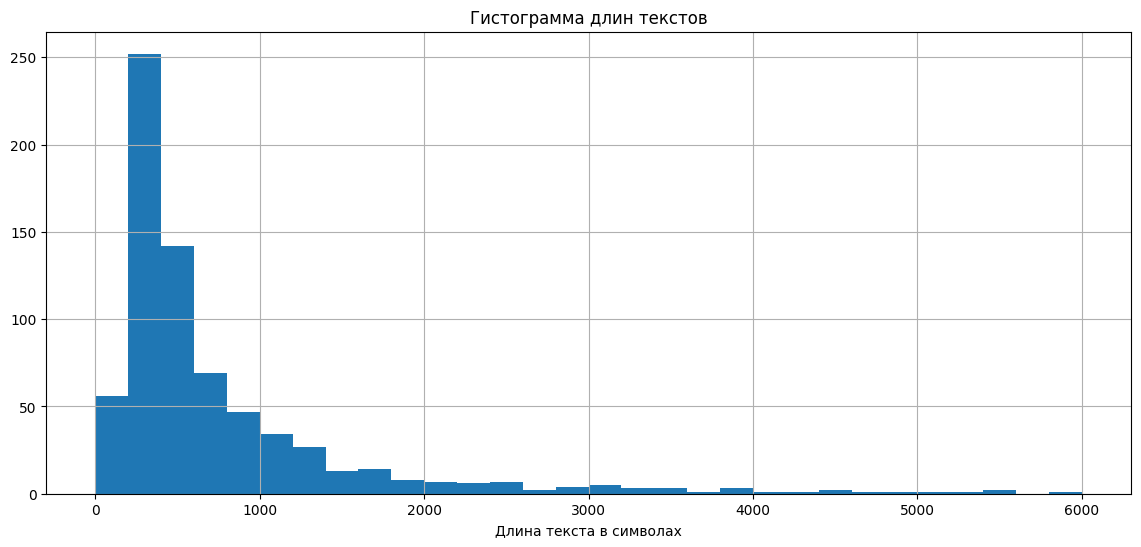

In [7]:
plt.rcParams["figure.figsize"] = (14, 6)
plt.hist(lengths, bins=30, range=[0, 6000])
plt.xlabel("Длина текста в символах")
plt.title("Гистограмма длин текстов")
plt.grid()

In [8]:
lengths = np.array(lengths)
print("Средняя длина", np.mean(lengths))
print("Медиана длины", np.median(lengths))
print("Мода длины", np.bincount(lengths).argmax())

Средняя длина 808.9125
Медиана длины 453.5
Мода длины 221


Где можно будет использовать знание о параметрах распределения длин в выборке?

In [9]:
# Устанавливаем, сколько символов будет генерировать модель (максимальная длина генерируемого текста)
MAXLEN = 500

###Преобразование данных

In [10]:
line_ix = [char2id[c] for c in data[5][:500]]

In [11]:
data_ix = np.zeros([len(data[5]), 500], 'int64')
data_ix[5, :len(line_ix)] = line_ix

In [12]:
data_ix= np.transpose(data_ix)
print(data_ix[5])

[0 0 0 ... 0 0 0]


In [13]:
def to_matrix(data, char2id, max_len=None, dtype='int64', batch_first = True):

    max_len = max_len if max_len else max(map(len, data))
    data = [text[:max_len] for text in data]
    data_ix = np.zeros([len(data), max_len+1], dtype)

    for i in range(len(data)):
        line_ix = [char2id[c] for c in data[i][:max_len]] + [char2id["EOS"]]
        data_ix[i, :len(line_ix)] = line_ix

    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [14]:
# Проверяем работу функции - кодируем один из текстов и смотрим как он выглядит в кодированном виде
encode = to_matrix(data[:1], char2id, MAXLEN)
print("Исходный текст:\n", data[0])
print("Преобразованный текст:\n", encode[0])

Исходный текст:
 Так и мне узнать случилось,
Что за птица Купидон;
Сердце страстное пленилось;
Признаюсь – и я влюблен!
Пролетело счастья время,
Как, любви не зная бремя,
Я живал да попевал,
Как в театре и на балах,
На гуляньях иль в воксалах
Легким зефиром летал;
Как, смеясь во зло Амуру,
Я писал карикатуру
На любезный женской пол;
Но напрасно я смеялся,
Наконец и сам попался,
Сам, увы! с ума сошел.
Смехи, вольность – всё под лавку
Из Катонов я в отставку,
И теперь я – Селадон!
Миловидной жрицы Тальи
Видел прелести Натальи,
И уж в сердце – Купидон!

Так, Наталья! признаюся,
Я тобою полонен,
В первый раз еще, стыжуся,
В женски прелести влюблен.
Целый день, как ни верчуся
Лишь тобою занят я;
Ночь придет – и лишь тебя
Вижу я в пустом мечтаньи,
Вижу, в легком одеяньи
Будто милая со мной;
Робко, сладостно дыханье,
Белой груди колебанье,
Снег затмивший белизной,
И полуотверсты очи,
Скромный мрак безмолвной ночи —
Дух в восторг приводят мой!..
Я один в беседке с нею,
Вижу… девственну лилею,


**Пояснить, что хранится в переменной encode.**

Переменная encode - вызывает функцию to_matrix для кодирования первого текста из списка data, используя словарь char2id, каждый символ текста заменяется на соответствующий ему числовой индекс из словаря char2id, и длина каждой строки задается максимальной длиной последовательности MAXLEN.


**Как будет выглядеть ваша фамилия в кодированном виде?**

In [15]:
name = 'Dvoryadkina'
encode = to_matrix(name, char2id, 5)
print("Исходный текст:\n", name)
print("Преобразованный текст:\n", encode)

Исходный текст:
 Dvoryadkina
Преобразованный текст:
 [[ 22   1   0   0   0   0]
 [  9   1   0   0   0   0]
 [116   1   0   0   0   0]
 [  4   1   0   0   0   0]
 [ 52   1   0   0   0   0]
 [ 31   1   0   0   0   0]
 [ 15   1   0   0   0   0]
 [120   1   0   0   0   0]
 [ 59   1   0   0   0   0]
 [ 30   1   0   0   0   0]
 [ 31   1   0   0   0   0]]


###Подготовка нейросети

In [16]:
num_embeddings = len(vocab) #количество эмбеддингов должно соответствовать длине словаря
embedding_dim = 32 #определяется размерность эмбеддинга
emb = nn.Embedding(num_embeddings, embedding_dim) # Определяем объект emb как слой эмбеддингов заданного размера

In [17]:
num_embeddings

143

**Почему количество эмбеддингов должно соответствовать длине словаря?**

 Либо будет недостаточно информации для представления всех слов или символов, либо будет избыточная информация, что может привести к переобучению модели. Это связано с тем, что каждый уникальный элемент должен иметь свое собственное представление в пространстве эмбеддингов.

**В качестве примера пропустим через этот слой первые 5 букв первого текста.**

In [18]:
# emb_out - 5 первых символов в виде эмбедингов
emb_out = emb(torch.tensor(encode[0][:5]))
print(f"Размер тензора: {emb_out.shape}\n")
print(emb_out)

Размер тензора: torch.Size([5, 32])

tensor([[ 1.6371, -0.0529,  1.5829, -0.0604, -1.1777,  1.6959,  0.6669, -0.7617,
         -0.4972,  0.4946, -0.0261,  1.2823,  0.3075, -0.6873, -0.1903,  0.6002,
         -0.4707, -0.9534,  0.0071, -0.9851, -0.1638,  1.0885,  0.1744,  2.0163,
          0.0893,  0.7502,  0.1848,  0.6972,  0.8728,  0.4923, -0.5697, -0.9653],
        [-0.8656, -0.3244,  0.2429, -0.5244,  1.1854,  0.1686,  0.3272,  0.8844,
         -0.2210,  0.3670, -1.2455, -0.4713,  1.1221, -1.2654, -0.3046,  0.3969,
         -0.1836,  1.4873,  1.3464, -0.0948,  0.2805, -0.3334, -1.2545,  0.2403,
          0.0824, -0.0135,  2.5436, -1.3603, -0.8398, -1.8277, -0.5974,  2.3347],
        [-1.6103, -0.7481,  1.2258, -0.8638,  0.0520,  0.1325,  0.5378,  0.2925,
         -0.5111, -0.3177,  1.1285, -0.2348, -0.3650,  1.0122,  0.2422,  1.0549,
          1.1638,  0.6109, -0.7850,  0.4967, -0.6920, -0.2218,  1.4511,  0.2411,
         -0.0613,  1.2391,  0.1106,  0.2983, -0.8744,  0.8380,  1.0889

**Пояснить, почему получен такой размер emb_out?**

Размер тензора: torch.Size([5, 32]) получается из того, что эмбеддинги применяются к первым пяти буквам из закодированной последовательности encode.  Каждая из пяти букв была преобразована в вектор размерности 32.

###Создадим ячейку GRU

**Обратиться к документации к nn.GRU и ответить на вопрос, за что отвечают параметры input_size, hidden_size, num_layers.**

input_size - количество ожидаемых функций во входных данных

hidden_size - количество объектов в скрытом состоянии

num_layers - количество повторяющихся слоев. Например, num_layers=2 будет означать объединение двух GRU вместе для формирования составного GRU, при этом второй GRU принимает выходные данные первого GRU и вычисляет окончательные результаты. По умолчанию: 1

In [19]:
# Определяем ячейку GRU в переменной gru, предварительно задав рамерность скрытого состояния и количество рекуррентных слоев
input_size = emb.embedding_dim # вход в GRU должен соответствовать размеру эмбеддинга
hidden_size = 60 #<your choice here>
num_layers = 2 #<your choice here>
gru = nn.GRU(input_size, hidden_size, num_layers)
output, h_n = gru(emb_out)
print("Размер output:", output.shape)
print("Размер h_n:", h_n.shape)

Размер output: torch.Size([5, 60])
Размер h_n: torch.Size([2, 60])


In [20]:
in_features = gru.hidden_size
out_features = len(vocab) #предсказываем букву из всего словаря
linear = nn.Linear(in_features, out_features) # Определяем линейный слой. Почему заданы такие входные и выходные параметры для него?
linear_out = linear(output) # output - выход GRU
print("Размер выходного слоя из нейросети: ", linear_out.shape)

Размер выходного слоя из нейросети:  torch.Size([5, 143])


Входные данные для линейного слоя будут иметь размерность, соответствующую размерности скрытого состояния GRU. Это связано с тем, что выходной результат GRU имеет размерность скрытого состояния.



**Что содержится в векторе linear_out?**

**Определить индекс символа, который наиболее вероятно выдаст ячейка GRU на первом шаге?**

In [21]:
linear_out[0]

tensor([ 0.0361, -0.0640,  0.0394, -0.0283, -0.0898,  0.0388,  0.1608, -0.1193,
        -0.1199, -0.1266, -0.0456, -0.0916,  0.0984,  0.0416,  0.0362, -0.0628,
        -0.0605,  0.1285, -0.0197,  0.0212, -0.0759, -0.1449,  0.0218,  0.0504,
         0.1132, -0.0138, -0.1027, -0.0834, -0.0024, -0.0411,  0.0865,  0.0806,
        -0.0400,  0.0132,  0.0087,  0.1963, -0.1185, -0.0260, -0.0384,  0.0945,
        -0.0407,  0.0679, -0.1504, -0.0553, -0.0082, -0.1166, -0.0238,  0.1043,
         0.0937,  0.1259, -0.0268,  0.0155,  0.0276,  0.0506, -0.0520,  0.0839,
         0.1025,  0.0542, -0.0251, -0.1095,  0.1437, -0.1144,  0.0884, -0.0302,
        -0.0884,  0.0793, -0.0562, -0.1171, -0.1134, -0.1003, -0.0665, -0.0578,
         0.1052, -0.0872, -0.0521, -0.0204,  0.0556, -0.0604,  0.0984,  0.1701,
        -0.0250, -0.1297, -0.0182,  0.0906, -0.0293,  0.0189,  0.0699, -0.1164,
         0.1224, -0.0438, -0.0670,  0.0918, -0.0004, -0.0513,  0.1124,  0.0343,
         0.0577, -0.0319, -0.0489, -0.11

In [22]:
class CharGRULoop(nn.Module): # Описываем инициализатор класса.
    def __init__(self, num_embeddings=52, embedding_dim=16, hidden_size=60, num_layers=2): # В методе __init__ определим архитектуру модели, создав необходимые слои
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(hidden_size, num_embeddings)

    def forward(self, x, hid_state): # Здесь описываем структуру сети - как сигнал должен по ней проходить
        x = self.emb(x) # Проходим через эмбеддинг-слой
        if hid_state is not None: # Проходим через GRU, сохраняя hidden state
            h_seq, hid_state = self.gru(x, hid_state)
        else:
            h_seq, hid_state = self.gru(x)
        next_logits = self.hid_to_logits(h_seq) # проходим через полносвязный слой
        next_logp = F.log_softmax(next_logits, dim=-1) # Используем функцию softmax
        return next_logp, hid_state

In [23]:
model = CharGRULoop(num_embeddings=len(vocab), embedding_dim=50, hidden_size=186, num_layers=3)
#<your choice here> Можно попробовать создать сеть с другими значениями параметров

In [24]:
!pip -q install torchinfo

In [25]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
CharGRULoop                              --
├─Embedding: 1-1                         7,150
├─GRU: 1-2                               550,188
├─Linear: 1-3                            26,741
Total params: 584,079
Trainable params: 584,079
Non-trainable params: 0

In [26]:
def generate_sample(model, char2id, id2char, seed_phrase=' ', strategy="greedy", max_length=100, temperature=1.0):
    """
      model - нейросеть
      char2id - словарь преобразования букв в их индексы
      id2char - словарь преобразования индексов в буквы
      seed_phrase - начальная фраза для генерации
      strategy - стратегия генерации (жадная "greedy" или сэмплирование "sample")
      max_length - максимальная длина сгенирированного текста
      temperature - ???
    """

    x_sequence = [char2id[token] for token in seed_phrase] # кодируем начальную фразу
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64) # создаем тензор
    hid_state = None # задаем тензор скрытого состояния h_n, при такой подачи вектор заполнится нулями

    with torch.no_grad(): # отключаем подсчет градиентов, поскольку сеть уже обучена и не нужно проводить обратное распространение ошибки
      for i in range(len(seed_phrase) - 1): # подаем номер буквы и hid_state в цикле
          _, hid_state = model(x_sequence[:, i].unsqueeze(0), hid_state)

      # начинаем генерацию
      for _ in range(max_length - len(seed_phrase)):

          logp_next, hid_state = model(x_sequence[:, -1].unsqueeze(0), hid_state) # подаем последнюю букву из фразы
          p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0] # нормируем выходы модели на температуру и применяем софтмакс

          if strategy == "greedy": next_ix = p_next.argmax() #берем токен с максимальной вероятностью
          elif strategy == "sample": next_ix = np.random.choice(len(id2char), p=p_next[0]) #получаем следующий токен сэмплированием с вероятностями
          else: raise ValueError('Хулиган, не делай так! Выбери "greedy" или "sample"')

          if id2char[next_ix] == "EOS": break # если получили токен EOS, то прекращаем генерацию
          else:
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64) # создаем тензор следующий буквы
            x_sequence = torch.cat([x_sequence, next_ix], dim=1) # добавляем предсказанный токен в конец последовательности

    return ''.join([id2char[ix] for ix in x_sequence.data.numpy()[0]]) # возвращаем декодированную строку

**Выполните следующую ячейку несколько раз с одной и той же SEED_PHRASE, запомните выводы модели и объясните результат - чем отличается стратегия greedy от sample?**

In [27]:
SEED_PHRASE = 'я люблю сырники!\n' # Ну или что-то другое
print(generate_sample(model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="greedy", max_length=100))
print()
print(generate_sample(model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="sample", max_length=100))

я люблю сырники!
uuûТPPТТûûPжжжжжжuuRuУuУ.u.шшшшшûûжжжжжжuuuRУУuu..шшшшшшûûжжжжжжuuuRУУuu..шшшшшшûûж

я люблю сырники!
NVçЕыFhûоû:сщцdJбФйèq!хN)tCЧ'ûФé;ШоЦьМHnЖшâAnэ*.йпвчSuБ«dюЧАL.âьХSnZХТувyç)"xBrмt'_


**Greedy** - для выбора следующего символа в тексте выбирается символ с наибольшей вероятностью, предсказанной моделью. Т.о., каждый следующий символ выбирается как наиболее вероятный, основываясь только на предсказаниях модели. Такие тексты короче (т.к. eos имеет высокую вероятность) и проще (больше похожих символов)

**Sample** - для выбора следующего символа используется случайный выбор с учетом вероятностей, предсказанных моделью. Эта стратегия приводит к более разнообразным и менее предсказуемым текстам.

In [28]:
from sklearn.model_selection import train_test_split

batch = 128 # Тексты, для уменьшения накладных расходов, будем подавать на вход модели "батчами" - блоками по 128 документов

train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

dataset_train = TensorDataset(torch.tensor(to_matrix(train, char2id, max_len=MAXLEN)))
dataloader_train = DataLoader(dataset_train, batch_size=batch, shuffle=True)

dataset_test = TensorDataset(torch.tensor(to_matrix(test, char2id, max_len=MAXLEN)))
dataloader_test = DataLoader(dataset_test, batch_size=batch, shuffle=False)

In [29]:
model = CharGRULoop(num_embeddings=len(vocab), embedding_dim=64, hidden_size=256, num_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.NLLLoss(ignore_index=char2id["PAD"])
# Функция потерь - negative log likelihood loss (NLL Loss) - используеся для задачи многоклассовой классификации в ситуации, когда имеются логарифмы вероятностей каждого класса
# NLL Loss эквивалентен CrossEntropyLoss, но применяется к логарифмам вероятностей - у нас на выходе линейного слоя как раз исопользуется функция softmax

summary(model)

Layer (type:depth-idx)                   Param #
CharGRULoop                              --
├─Embedding: 1-1                         9,152
├─GRU: 1-2                               1,036,800
├─Linear: 1-3                            36,751
Total params: 1,082,703
Trainable params: 1,082,703
Non-trainable params: 0

In [30]:
train[:1]

['Буря мглою небо кроет,\nВихри снежные крутя:\nТо, как зверь, она завоет,\nТо заплачет, как дитя,\nТо по кровле обветшалой\nВдруг соломой зашумит,\nТо, как путник запоздалый,\nК нам в окошко застучит.\n\nНаша ветхая лачужка\nИ печальна, и темна.\nЧто же ты, моя старушка,\nПриумолкла у окна?\nИли бури завываньем\nТы, мой друг, утомлена,\nИли дремлешь под жужжаньем\nСвоего веретена?\n\nВыпьем, добрая подружка\nБедной юности моей,\nВыпьем с горя; где же кружка?\nСердцу будет веселей.\nСпой мне песню, как синица\nТихо за морем жила;\nСпой мне песню, как девица\nЗа водой поутру шла.\n\nБуря мглою небо кроет,\nВихри снежные крутя;\nТо, как зверь, она завоет.\nТо заплачет, как дитя.\nВыпьем, добрая подружка\nБедной юности моей,\nВыпьем с горя; где же кружка?\nСердцу будет веселей.\n\n']

In [31]:
example = torch.tensor(to_matrix(train[:1], char2id, max_len=MAXLEN)) # Возьмем первый документ и попробуем сгененировать этот же текст начиная с первой буквы

train_example = example[:, :-1]
target_example = example[:, 1:]

next_logp, hid_state = model(train_example, hid_state=None)

print('perplexity: ', torch.exp(loss_fn(next_logp.permute(0, 2, 1), target_example)).item())

perplexity:  143.99952697753906


In [32]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.empty_cache()

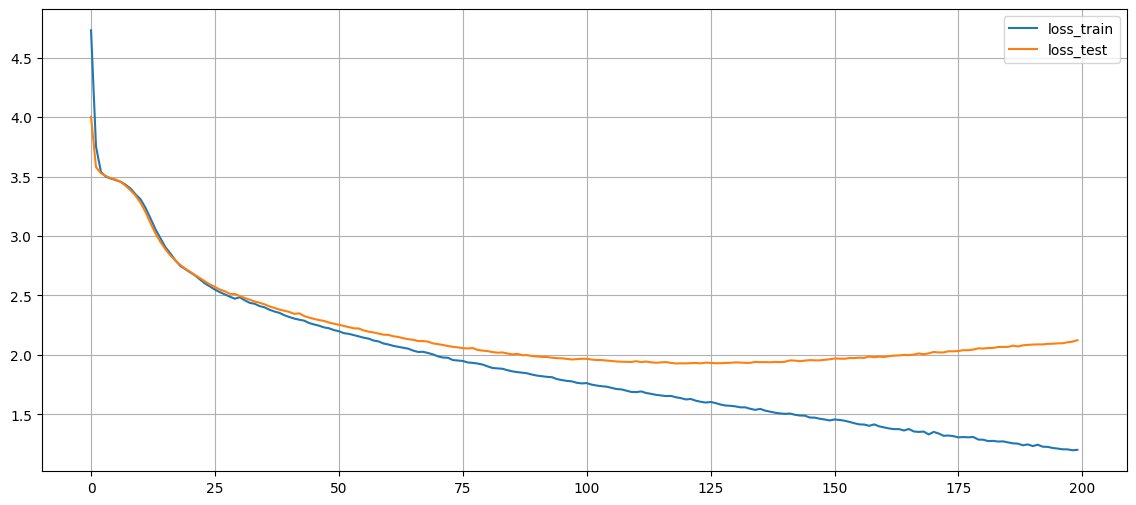

In [33]:
EPOCH = 200 # количество эпох обучения
history_train = [] # список значений лосса трейна на каждой эпохи
history_test = [] # список значений лосса теста на каждой эпохи
model.to(device) # И модель, и данные должны находиться на одном устройстве.
                 # Поэтому при работе с GPU нужно следить и явно указывать, на каком устройстве проводится работа.


best_test_loss = float("inf")
for i in range(EPOCH): #цикл по эпохам

  loss_test = 0
  loss_train = 0

  for batch in dataloader_train: #цикл по тренировачным батчам

    optimizer.zero_grad() #обнуляем градиенты
    batch_ix = torch.tensor(batch[0], dtype=torch.int64).to(device) #делаем из батча тензор

    predictions_logp, _ = model(batch_ix[:, :-1], hid_state=None) #подаем батч в модель

    actual_next_tokens = batch_ix[:, 1:] # таргеры

    loss = loss_fn(predictions_logp.permute(0, 2, 1), actual_next_tokens.long()) # считаем лосс на батче
    loss_train += loss.item() # добавляем лосс с батча в суммарный лосс

    loss.backward() # делаем обратный проход
    optimizer.step() # делаем шаг оптимизатором

  history_train.append(loss_train/len(dataloader_train)) # добавляем  средний лосс за эпоху в список

  for batch in dataloader_test: #цикл по тестовым батчам
    with torch.no_grad(): # отключаем подсчет градиентов

      batch_ix = torch.tensor(batch[0], dtype=torch.int64).to(device)
      predictions_logp, _ = model(batch_ix[:, :-1], hid_state=None)

      actual_next_tokens = batch_ix[:, 1:]

      loss = loss_fn(predictions_logp.permute(0, 2, 1), actual_next_tokens.long())
      loss_test += loss.item()

  loss_test = loss_test/len(dataloader_test)
  history_test.append(loss_test)

  if loss_test < best_test_loss: #сохраняем лучшую модель по лоссу на тесте
    best_test_loss = loss_test
    best_model = copy.deepcopy(model)
    best_model.to("cpu")

  if (i + 1) % 5 == 0: # выводим график лосса каждые 5 эпох
    clear_output(True)
    plt.plot(history_train, label='loss_train')
    plt.plot(history_test, label='loss_test')
    plt.grid()
    plt.legend()
    plt.show()

**Достаточно ли обучилась модель? Имеет ли смысл изменить количество эпох обучения?**


In [34]:
print("perplexity (best model test): ", np.exp(best_test_loss))
print("perplexity (last epoch test): ", np.exp(loss_test))

perplexity (best model test):  6.874816613361376
perplexity (last epoch test):  8.362294116092965


In [35]:
device = 'cpu' # Обучение обычно проводится на GPU, но чтобы не тратить его ресурсы, работу по генерации текста уже обученной моделью стоит перенести обратно на CPU
model.to(device)

CharGRULoop(
  (emb): Embedding(143, 64)
  (gru): GRU(64, 256, num_layers=3, batch_first=True)
  (hid_to_logits): Linear(in_features=256, out_features=143, bias=True)
)

In [36]:
#Если вы не согласны, вы можете поменять стартовую фразу, но что думает об этом высказывание машина?
SEED_PHRASE = 'Я люблю сырники,'

In [37]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="sample", max_length=MAXLEN))

Я люблю сырники, но богатор,
Коржашен святый лес вод.
Не дремлюсь и места, гресне!
Царьме и холитель в той? —
В, ей дере верен гпестме,
Не буще круг старью, любовь лочь,
Всё юностарь, ненавиделся
Скольски лы, за вела...
Где ль развясь, не как новы?

Жувственные летит,
Делаче садие старожно
Неведающесь живой,
Где мысла непоезный,
Пора, питами и Пылаю.

Не воздысли страсть а церный,
Мо 


In [38]:
prompt = "Время спать уже"
print(generate_sample(model, char2id, id2char, seed_phrase=prompt, strategy="sample", max_length=256))

Время спать ужели холодной
Парнащие печали любви
Ты кливого врага вот поли.
Как непостоют будут дней
Так видишь – и зажестивый,
Не падругой и бейзать,
И в стеснею воображенья
И оковы рассказые,
Обы его быть бежал
С героею, пристаюсь,
Не тут полгой, ты вдох


In [39]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="greedy", max_length=MAXLEN))

Я люблю сырники, старик страстью,
Под сердце прости и страсть
И с тобой волненье моей.




In [40]:
print(generate_sample(model, char2id, id2char, seed_phrase=prompt, strategy="greedy", max_length=256))

Время спать уже с восколюбить,
Во мне то будет в небеса,
Не встречать не смеют посланье,
Но с тобой покой и глазам
И сердце на под небеса,
И ты по не у нас ума.

И вы, которы тебя любила
И с ней собой не разбудит на бару,
На воле за черно возвесть.

В то в


###Эксперименты с температурой

In [41]:
nice_strategy = "sample" #<your choice here>

In [42]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy=nice_strategy, max_length=MAXLEN, temperature=2.0))

Я люблю сырники,
Кт


In [43]:
print(generate_sample(best_model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy=nice_strategy, max_length=MAXLEN, temperature=0.5))

Я люблю сырники, с себя достучей
Сирой не желать в изменились великой
И даго будет в дале собою
Простеренней и томных поле,
И дертвенный сердце внемлет на верего,
Так презвышен благословенный день.




**Сделайте выводы как влияет изменение температуры на генерацию текста.**

Чем ниже температура, тем больший смысл имеет текст, но при этом уменьшается разнообразие используемых слов.

**Выберите оптимальное значение температуры**

0,5 показывает достаточно понятный текст

In [44]:
# По завершению работы с рекуррентной сетью, очистим кэш
torch.cuda.empty_cache()

###Bonus track GPT